<a href="https://colab.research.google.com/github/AidanRidderhof/image-classifier/blob/main/Ridderhof_Aidan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
#from sklearn.model_selection import train_test_split
import sklearn.model_selection as skl
from skimage.color import rgb2gray
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sn
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
import sklearn.ensemble as rfc
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression

from PIL import Image
from torch import nn
import torchvision.models as models
from torchvision import transforms
from torchsummary import summary

import time

In [ ]:
drive.mount('/content/drive/')
!unzip "/content/drive/MyDrive/Copy of Intel Training Dataset.zip"

In [3]:
# Path to Dataset
root_path = './Intel Training Dataset/'

# split into subfolders based on class label
subfolders = sorted(glob(root_path + '*'))
label_names = [p.split('/')[-1] for p in subfolders]
print(label_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [4]:
# load the model
resnet50 = models.resnet50(pretrained=True)

# drop the last layer of the network that outputs a classification probability

# this function gets all the layers of the network
def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])

# this step grabs all but the last layer and transfers it to the cpu
model_conv_features = slice_model(resnet50, to_layer=-1).to('cpu')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.7MB/s]


In [5]:
# pre-processing steps required by ResNet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# make sure images are of the correct data type
def retype_image(in_img):
  if np.max(in_img) > 1:
    in_img = in_img.astype(np.uint8)
  else:
    in_img = (in_img * 255.0).astype(np.uint8)
  return in_img

# put the model in evaluation mode
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
#extract features
start = time.time()

features = []
labels = []
for i in range(len(subfolders)):
  # get all filepaths
  fnames = sorted(glob(subfolders[i]+'/*.jpg'))

  for j in range(len(fnames)):
    img = plt.imread(fnames[j])
    proc_img = preprocess(Image.fromarray(img))
    feat = model_conv_features(proc_img.unsqueeze(0).to('cpu')).squeeze().detach().numpy()
    features.append(feat)
    labels.append(i)

features = np.array(features)

end = time.time()

labels = np.array(labels)
print(features.shape)
time1 = end-start
print('feature vectore time: {}'.format(time1))

(9820, 2048)
feature vectore time: 2489.048224210739


In [7]:
# Split the data into train and test set
X_train, X_test, y_train, y_test = skl.train_test_split(
    features,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=0,
)

In [8]:
print(features.shape)

(9820, 2048)


In [11]:
#classification
start = time.time()

clf = rfc.RandomForestClassifier(n_estimators=200, criterion= 'gini', max_depth=20)

clf.fit(X_train, y_train)

end = time.time()
time2 = end-start
print('training time: {}'.format(time2))

start = time.time()
print('Total Accuracy: {}'.format(clf.score(X_test, y_test)))

end = time.time()
time3 = end-start
print('testing time: {}'.format(time3))

training time: 139.80472326278687
Total Accuracy: 0.9073319755600815
testing time: 0.12661528587341309


In [ ]:
#grid search
param_grid = {
    'n_estimators': [200],
    'criterion': ['gini'],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = skl.GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True, verbose=10)
grid_search.fit(X_train, y_train)

<Axes: >

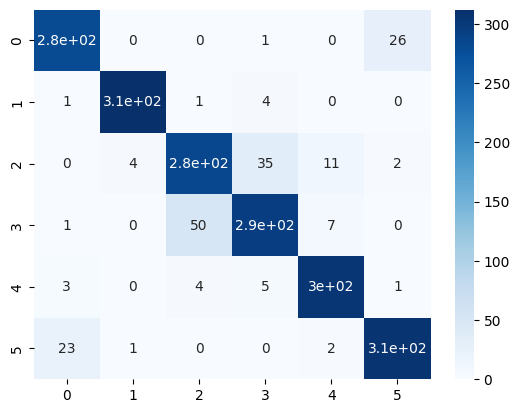

In [12]:
#Confusion Matrix
y_pred = clf.predict(X_test)

# Plot the results as a confusion matrix
C = confusion_matrix(y_test, y_pred)
sn.heatmap(C, annot=True, cmap='Blues')